In [54]:
import pandas as pd 


train = pd.read_csv('E:/python/sale_forecast/data/sales_train.csv')
test = pd.read_csv('E:/python/sale_forecast/data/sales_test.csv')
# solusion = pd.read_csv('E:/python/sale_forecast/data/solution.csv')
inv = pd.read_csv('E:/python/sale_forecast/data/inventory.csv')
cal = pd.read_csv('E:/python/sale_forecast/data/calendar.csv')

train = train.merge(inv, on = ['warehouse','unique_id'], how = 'left')
train['unique_id_and_name'] = train['unique_id'].astype(str) + '_' + train['name']
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])


# cal['is_holiday'] = ((cal['holiday_name'] != 'None') & (cal['shops_closed'] != '0')).map({True: 'yes', False: 'no'}).astype('category')
# 将cal和train合并，以data和 warehouse为主键
cal['date'] = pd.to_datetime(cal['date'])
train = train.merge(cal, on = ['warehouse','date'], how = 'left')
train = train.drop(columns = ['holiday_name', 'shops_closed','holiday','winter_school_holidays','school_holidays'])


# 将train变为时间序列
train = train.set_index('date')


train.head()


,unique_id,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,unique_id_and_name
date,,,,,,,,,,,,,,,,,,,,
2024-03-10,4845,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4845_Croissant_35
2021-05-25,4845,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4845_Croissant_35
2021-12-20,4845,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4845_Croissant_35
2023-04-29,4845,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4845_Croissant_35
2022-04-01,4845,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,4845_Croissant_35


In [ ]:
## 检查空值，采取插值或者删除                
train.isnull().sum()


## 采取插值，填充空值
train['total_orders'] = train['total_orders'].interpolate(method='time')
train['sales'] = train['sales'].interpolate(method='time')
train['sales'] = train['sales'].fillna(0)
train['total_orders'] = train['total_orders'].fillna(0)
train.isnull().sum()


# 将train还原为dataframe
train = train.reset_index()
train.head()

In [ ]:
# add time index
min_time_idx = train['date'].min()
train['time_idx'] = (train['date'] - min_time_idx).dt.days
train['unique_id'] = train['unique_id'].astype(str).astype('category')
test['time_idx'] = (test['date'] - min_time_idx).dt.days
test['unique_id'] = test['unique_id'].astype(str).astype('category')
test['sales'] = 0.0
test = pd.concat([train, test], ignore_index=True)
test.isnull().sum()



date                       0
unique_id                  0
warehouse                  0
total_orders               0
sales                      0
sell_price_main            0
availability           47021
type_0_discount            0
type_1_discount            0
type_2_discount            0
type_3_discount            0
type_4_discount            0
type_5_discount            0
type_6_discount            0
product_unique_id      47021
name                   47021
L1_category_name_en    47021
L2_category_name_en    47021
L3_category_name_en    47021
L4_category_name_en    47021
unique_id_and_name     47021
time_idx                   0
dtype: int64

In [ ]:
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
max_prediction_length = 28
max_encoder_length = 28
training_cutoff = train["time_idx"].max() # - max_prediction_length

# print(train['is_holiday'].dtype)  # 应该显示 category


training = TimeSeriesDataSet(
    train, #[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["unique_id"],
    min_encoder_length=1, # max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[
        "unique_id",
        'warehouse',
        # 'is_holiday',
    ],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "time_idx",
        'total_orders',
        'sell_price_main',
        'type_0_discount',
        'type_1_discount',
        'type_2_discount',
        'type_3_discount',
        'type_4_discount',
        'type_5_discount',
        'type_6_discount',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'sales',
    ],
    target_normalizer=GroupNormalizer(
        groups=["unique_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0) # batch_size=batch_size * 10

e:\applist\miniconda\envs\tensor\lib\site-packages\pytorch_forecasting\data\timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 460 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__unique_id': '0'}, {'__group_id__unique_id': '1000'}, {'__group_id__unique_id': '1005'}, {'__group_id__unique_id': '1018'}, {'__group_id__unique_id': '103'}, {'__group_id__unique_id': '1069'}, {'__group_id__unique_id': '1081'}, {'__group_id__unique_id': '1085'}, {'__group_id__unique_id': '1141'}, {'__group_id__unique_id': '1180'}]
  warnings.warn(


In [ ]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE
import pytorch_lightning as pl
import torch
import os
from tqdm import tqdm


print(f"gpu available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available. Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Check if CUDA (GPU) is available
# Define the model (TFT)
tft = TemporalFusionTransformer.from_dataset(
    training,  # 假设 'training' 数据集已经定义好
    loss=MAE(),
    log_interval=10, # This will be ignored as we are not using Trainer's logging
    optimizer="adamw",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Move model to the selected device (CPU or GPU)
tft.to(device)
print(f"Type of tft.optimizer: {type(tft.optimizer)}")

# Create optimizer
optimizer = torch.optim.AdamW(tft.parameters())

# # Get data loaders from the training dataset
# train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0) # Adjust batch_size and num_workers as needed
# val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=0) # Adjust batch_size and num_workers as needed

# Training loop parameters
max_epochs = 200
gradient_clip_val = 0.1
limit_train_batches = 50 # For demonstration, remove or adjust as needed
best_val_loss = float('inf')  # 初始化最佳验证损失为无穷大
best_model_path = "best_tft_model.pth"  # 定义模型保存路径

# Training loop
for epoch in range(max_epochs):
    tft.train() # Set model to training mode
    total_loss = 0.0
    processed_batches = 0
    progress_bar = tqdm(enumerate(train_dataloader), total=min(limit_train_batches, len(train_dataloader)) if limit_train_batches else len(train_dataloader), desc=f"Epoch {epoch+1}/{max_epochs} (Training)")

    for batch_idx, (x, y) in progress_bar:
        if limit_train_batches and batch_idx >= limit_train_batches:
            break # Limit train batches for demonstration

        # Move data to device
        x = {k: v.to(device) for k, v in x.items()} # Move input features to device

        # Handle target variable properly
        if isinstance(y, tuple):
            y = y[0].to(device)
        elif hasattr(y, 'values'):
            y = y.values.to(device)
        else:
            y = y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        y_hat = tft(x) # Get predictions

        # Calculate loss
        loss = tft.loss(y_hat.prediction, y)  # Access the .prediction attribute

        # Backward pass
        loss.backward()

        # Gradient clipping (optional but good practice)
        torch.nn.utils.clip_grad_norm_(tft.parameters(), gradient_clip_val)

        # Optimizer step
        optimizer.step()

        total_loss += loss.item()
        processed_batches += 1
        progress_bar.update(1)  # 更新进度条


        # avg_loss = total_loss / processed_batches if processed_batches > 0 else 0
        # progress_bar.set_postfix({"train_loss": f"{avg_loss:.4f}"})


    avg_epoch_loss = total_loss / processed_batches if processed_batches > 0 else 0
    progress_bar.close() # 关闭进度条

    print(f"Epoch {epoch+1}/{max_epochs} Training Loss: {avg_epoch_loss:.4f}")

    # Validation loop (Optional - but highly recommended)
    tft.eval() # Set model to evaluation mode
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad(): # Disable gradient calculations during validation
        val_progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f"Epoch {epoch+1}/{max_epochs} (Validation)")
        for batch_idx, (x, y) in val_progress_bar:
            # Move data to device
            x = {k: v.to(device) for k, v in x.items()}
            y = (y[0].to(device), y[1] if y[1] is not None else None)

            # Forward pass (no gradients needed)
            y_hat = tft(x)

            # Calculate loss
            loss = tft.loss(y_hat.prediction, y)

            val_loss += loss.item()
            val_batches += 1
            val_progress_bar.update(1) # 更新验证进度

    avg_epoch_val_loss = val_loss / val_batches if val_batches > 0 else 0
    val_progress_bar.set_postfix({"val_loss": f"{avg_epoch_val_loss:.4f}"})
    val_progress_bar.close()  # 关闭验证进度条

    print(f"Epoch {epoch+1}/{max_epochs} Validation Loss: {avg_epoch_val_loss:.4f}")
    
    
    
    
            # 保存最佳模型
    if avg_epoch_val_loss < best_val_loss:
        best_val_loss = avg_epoch_val_loss
        torch.save(tft.state_dict(), best_model_path)  # 保存模型状态字典
        print(f"Epoch {epoch+1}: Best model saved to {best_model_path}")

print("Training finished!")

gpu available: False
GPU not available, CPU used


e:\applist\miniconda\envs\tensor\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
e:\applist\miniconda\envs\tensor\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 117.5k
Type of tft.optimizer: <class 'str'>


Epoch 1/5 (Training): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 1/5 Training Loss: 44.7585


Epoch 1/5 (Validation): 100%|██████████| 39/39 [00:06<00:00,  5.59it/s]


Epoch 1/5 Validation Loss: 44.6868
Epoch 1: Best model saved to best_tft_model.pth


Epoch 2/5 (Training): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 2/5 Training Loss: 43.2082


Epoch 2/5 (Validation): 100%|██████████| 39/39 [00:06<00:00,  5.73it/s]


Epoch 2/5 Validation Loss: 41.9032
Epoch 2: Best model saved to best_tft_model.pth


Epoch 3/5 (Training): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 3/5 Training Loss: 34.7381


Epoch 3/5 (Validation): 100%|██████████| 39/39 [00:06<00:00,  5.68it/s]


Epoch 3/5 Validation Loss: 42.2726


Epoch 4/5 (Training): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 4/5 Training Loss: 37.1661


Epoch 4/5 (Validation): 100%|██████████| 39/39 [00:06<00:00,  5.67it/s]


Epoch 4/5 Validation Loss: 42.0507


Epoch 5/5 (Training): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Epoch 5/5 Training Loss: 33.3782


Epoch 5/5 (Validation): 100%|██████████| 39/39 [00:07<00:00,  5.38it/s]

Epoch 5/5 Validation Loss: 40.7311
Epoch 5: Best model saved to best_tft_model.pth
Training finished!


In [ ]:
# Create a new model instance with the same configuration as before
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    loss=MAE(),
    log_interval=10,
    optimizer="adamw",
)

# Load the saved state dictionary
best_tft.load_state_dict(torch.load(best_model_path))
best_tft.to(device)
best_tft.eval()  # Set to evaluation mode



# First, ensure test data is processed with add_nan=True
raw_predictions = best_tft.predict(test,
                                   mode="raw", 
                                   return_x=True, 
                                   return_index=True)

# print(f"detail of raw_predictions: {raw_predictions}")

C:\Users\16972\AppData\Local\Temp\ipykernel_25104\1514736447.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_tft.load_state_dict(torch.load(best_model_path))
e:\ap

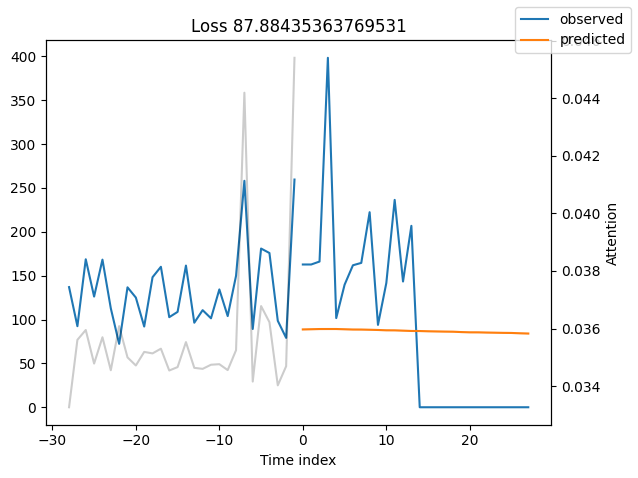

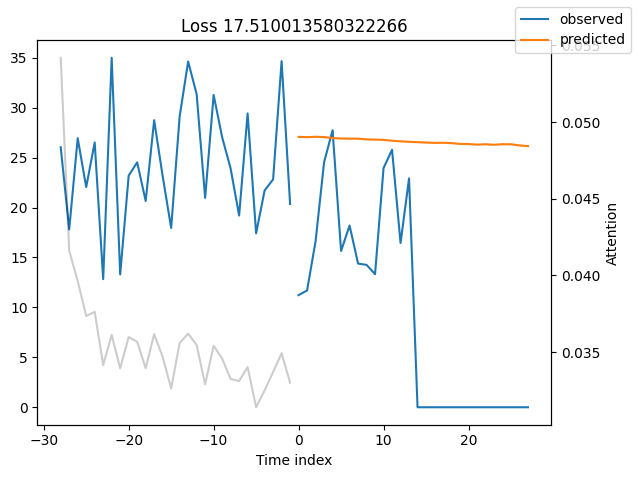

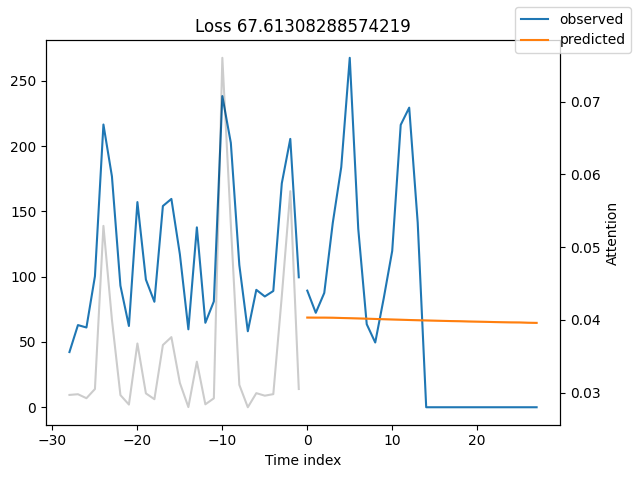

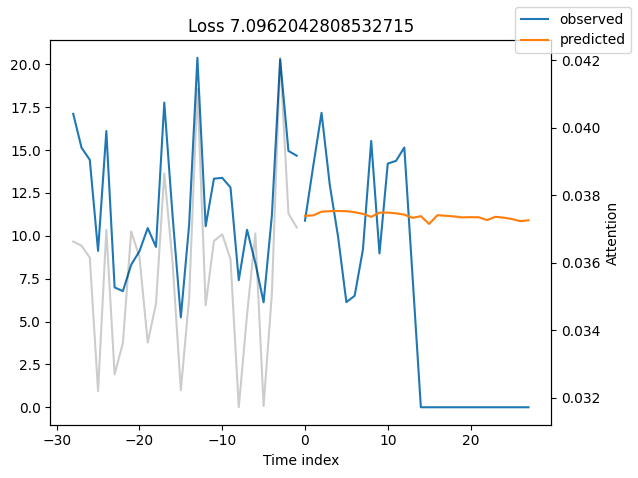

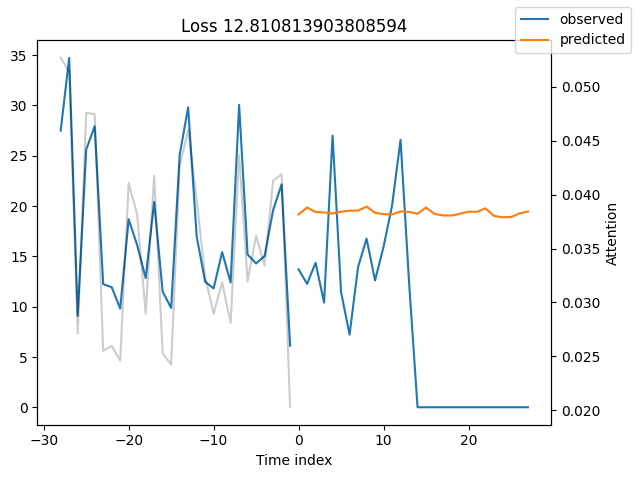

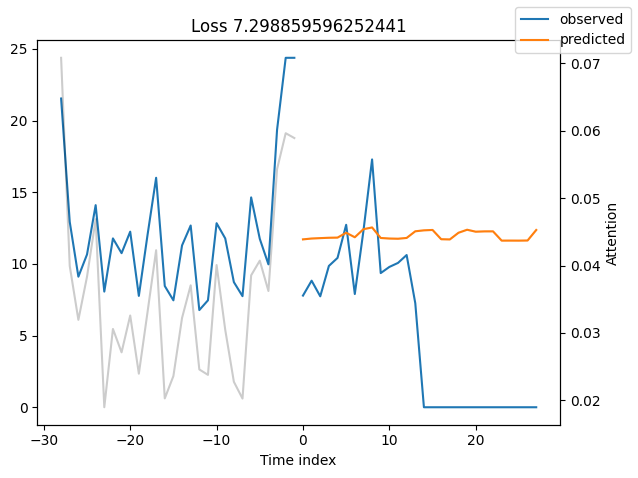

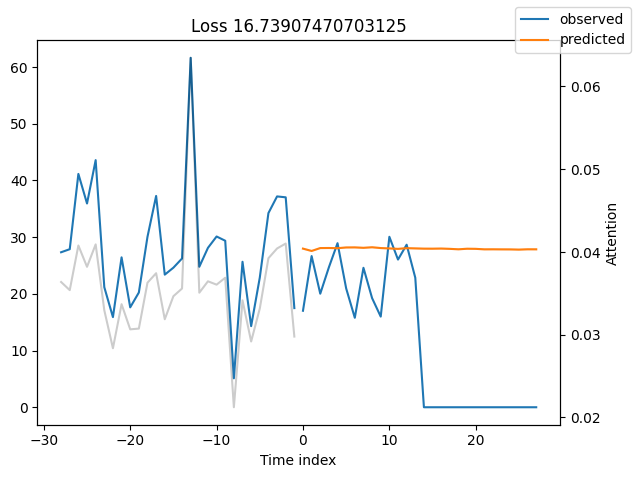

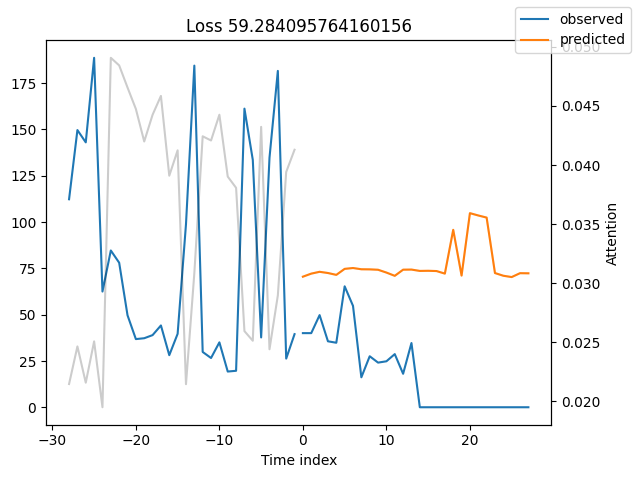

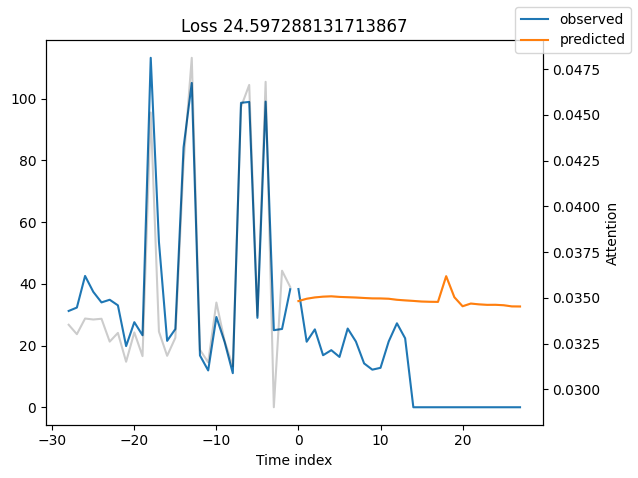

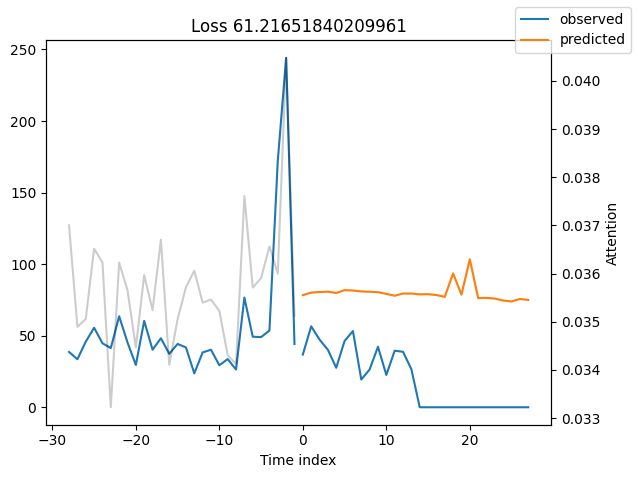

In [ ]:
for idx in range(10):
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [ ]:
pred_index = raw_predictions.index
preds = raw_predictions.output.prediction.cpu()

# pred_index.time_idx.count()

solution = pd.read_csv('E:/python/sale_forecast/data/solution.csv')
solution = solution[['id']]
solution[['unique_id', 'date']] = solution['id'].str.split('_', expand=True)

solution['date'] = pd.to_datetime(solution['date'])
start_date = train['date'].min()
solution['time_idx'] = (solution['date'] - start_date).dt.days

solution.head()


,id,unique_id,date,time_idx
0,1226_2024-06-03,1226,2024-06-03,1402
1,1226_2024-06-11,1226,2024-06-11,1410
2,1226_2024-06-13,1226,2024-06-13,1412
3,1226_2024-06-15,1226,2024-06-15,1414
4,1226_2024-06-09,1226,2024-06-09,1408


In [ ]:
import numpy as np


print(f"preds.shape: {preds.shape}")
preds = preds.squeeze(-1).numpy()

horizon = preds.shape[1]
pred_index['forecast_idx'] = range(len(pred_index))

expand_forecast = []

for idx, row in pred_index.iterrows():
    start_time_idx = row["time_idx"]
    unique_id = row["unique_id"]
    forecast_values = preds[idx]
    time_indices = np.arange(start_time_idx, start_time_idx + horizon)
    
    expand_forecast.append(pd.DataFrame({
        "time_idx": time_indices,
        "unique_id": unique_id,
        "sales_hat": forecast_values
    }))

expanded_forecasts_df = pd.concat(expand_forecast, ignore_index=True)

solution = solution.merge(expanded_forecasts_df, on=["unique_id", "time_idx"], how="left")
solution.isna().sum()

preds.shape: torch.Size([4946, 28, 1])


id              0
unique_id       0
date            0
time_idx        0
sales_hat    1335
dtype: int64